In this experiment, I built a deep convolutional network with residual blocks as introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), using the starting code, hints, dataset and utility functions from the [Convolutional Neural Networks](https://coursera.org/learn/convolutional-neural-networks) course (offered by DeepLearning.AI on Coursera).

I built a ResNet-50 model with TensorFlow to classify how many fingers in an image, as described in this figure (from Coursera), which is comprised of identity blocks and convolutional blocks:
![resnet_kiank.png](images%2Fresnet_kiank.png)

The identity blocks and residual blocks have skip connections to prevent the vanishing/exploding gradient problems:

Identity block:
![idblock2_kiank.png](images%2Fidblock2_kiank.png)

Convolutional block:
![convblock_kiank.png](images%2Fconvblock_kiank.png)




In [3]:
import tensorflow as tf
import numpy as np
import scipy.misc
import keras.api._v2.keras as keras
from keras.applications.resnet_v2 import ResNet50V2
from keras.preprocessing import image
from keras.applications.resnet_v2 import preprocess_input, decode_predictions
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from resnets_utils import *
from keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

from test_utils import summary, comparator
import public_tests
%matplotlib inline
np.random.seed(1)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Building ResNet model

In [4]:
def identity_block(X, f, filters, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    F1, F2, F3 = filters
    X_shortcut = X
    # First component of main path
    import tensorflow as tf
    X = keras.layers.Conv2D(filters=F1, kernel_size=1, strides=1, padding="valid", kernel_initializer=initializer(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X, training=tf.keras.backend.learning_phase())
    X = keras.layers.Activation('relu')(X)
    # Second component of main path
    X = keras.layers.Conv2D(filters=F2, kernel_size=f, strides=1, padding="same", kernel_initializer=initializer(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X, training=tf.keras.backend.learning_phase())
    X = keras.layers.Activation('relu')(X)
    # Third component of main path
    X = keras.layers.Conv2D(filters=F3, kernel_size=1, strides=1, padding="valid", kernel_initializer=initializer(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X, training=tf.keras.backend.learning_phase())

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X

In [5]:

def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    F1, F2, F3 = filters
    X_shortcut = X
    # First component of main path
    X = keras.layers.Conv2D(filters=F1, kernel_size=1, strides=s, padding="valid", kernel_initializer=initializer(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X, training=keras.backend.learning_phase())
    X = keras.layers.Activation('relu')(X)
    # Second component of main path
    X = keras.layers.Conv2D(filters=F2, kernel_size=f, strides=1, padding="same", kernel_initializer=initializer(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X, training=keras.backend.learning_phase())
    X = keras.layers.Activation('relu')(X)
    # Third component of main path
    X = keras.layers.Conv2D(filters=F3, kernel_size=1, strides=1, padding="valid", kernel_initializer=initializer(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X, training=keras.backend.learning_phase())
    # Conv2D on the shortcut path
    X_shortcut = keras.layers.Conv2D(filters=F3, kernel_size=1, strides=s, padding="valid", kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis=3)(X_shortcut, training=keras.backend.learning_phase())
    # Adding and ReLU
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)
    return X



In [6]:
def ResNet50(input_shape = (64, 64, 3), classes = 6, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    X_input = keras.Input(shape=input_shape)

    # Zero-padding
    X = keras.layers.ZeroPadding2D(padding=(3,3))(X_input)
    # Stage 1: CONV - BatchNorm - ReLU - MaxPool
    X = keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer=glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=3, strides=2)(X)
    # Stage 2: Conv block - ID block x2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])
    X = identity_block(X, f=3, filters=[64, 64, 256])
    # Stage 3: Conv block - ID block x3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    # Stage 4: Conv block - ID block x5
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    # Stage 5: Conv block - ID block x2
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, f=3, filters=[512, 512, 2048])
    X = identity_block(X, f=3, filters=[512, 512, 2048])
    # Avg Pool - Flatten - FC
    X = keras.layers.AveragePooling2D(pool_size=2)(X)
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(units=classes, activation="softmax", kernel_initializer=glorot_uniform(seed=0))(X)
    model = keras.Model(inputs=X_input, outputs=X)

    return model

In [21]:
tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 70, 70, 3)            0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_53 (Conv2D)          (None, 32, 32, 64)           9472      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_53 (Ba  (None, 32, 32, 64)           256       ['conv2d_53[0][0]']     

In [22]:
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
opt = keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Loading training data

In [23]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


# Train the model

In [24]:
model.fit(X_train, Y_train, epochs = 30, batch_size = 32)

Epoch 1/30
34/34 [==============================] - 28s 56ms/step - loss: 1.7479 - accuracy: 0.3657
Epoch 2/30
34/34 [==============================] - 2s 53ms/step - loss: 0.9705 - accuracy: 0.6398
Epoch 3/30
34/34 [==============================] - 2s 53ms/step - loss: 0.5633 - accuracy: 0.8046
Epoch 4/30
34/34 [==============================] - 2s 53ms/step - loss: 0.2990 - accuracy: 0.8898
Epoch 5/30
34/34 [==============================] - 2s 54ms/step - loss: 0.2070 - accuracy: 0.9194
Epoch 6/30
34/34 [==============================] - 2s 54ms/step - loss: 0.1403 - accuracy: 0.9509
Epoch 7/30
34/34 [==============================] - 2s 54ms/step - loss: 0.1025 - accuracy: 0.9620
Epoch 8/30
34/34 [==============================] - 2s 54ms/step - loss: 0.1318 - accuracy: 0.9583
Epoch 9/30
34/34 [==============================] - 2s 55ms/step - loss: 0.0801 - accuracy: 0.9759
Epoch 10/30
34/34 [==============================] - 2s 54ms/step - loss: 0.0929 - accuracy: 0.9713
Epoch 11

In [25]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 16ms/step - loss: 0.3740 - accuracy: 0.9083
Loss = 0.37404611706733704
Test Accuracy = 0.9083333611488342


x.shape = (64, 64, 3)
Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 25ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[0.2237433  0.03675142 0.05643783 0.45737165 0.1879786  0.03771722]]
Number of fingers: 3


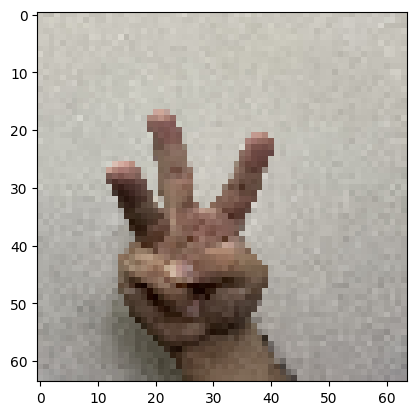

In [38]:
img_path = 'images/my_image_3.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
print(f"x.shape = {x.shape}")
x = x.swapaxes(0, 1)
x = x/255.0
imshow(x)
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)
prediction = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Number of fingers:", np.argmax(prediction))